In [ ]:
!pip install geopandas requests geojson rasterio rasterstats matplotlib pandas


In [ ]:
# Importar bibliotecas
import geopandas as gpd
import numpy as np
import pandas as pd
import requests
import geojson
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from rasterstats import zonal_stats
from io import BytesIO
from shapely.geometry import box


## 1. Carregando a camada vetorial dos municípios da Amazônia

In [ ]:
mun_url = "https://info.dengue.mat.br/geoserver/wfs"

# Parâmetros para conectar com a camada vetorial
params_AML = dict(
    service="WFS",
    version="2.0.0",
    request="GetFeature",
    typeName="amazonia_legal_mun_2022",
    outputFormat="json",
)

# Fazendo o request
r_AML = requests.get(mun_url, params=params_AML)

# Baixando e carregando a camada
municipios = gpd.GeoDataFrame.from_features(geojson.loads(r_AML.content), crs="EPSG:4674")


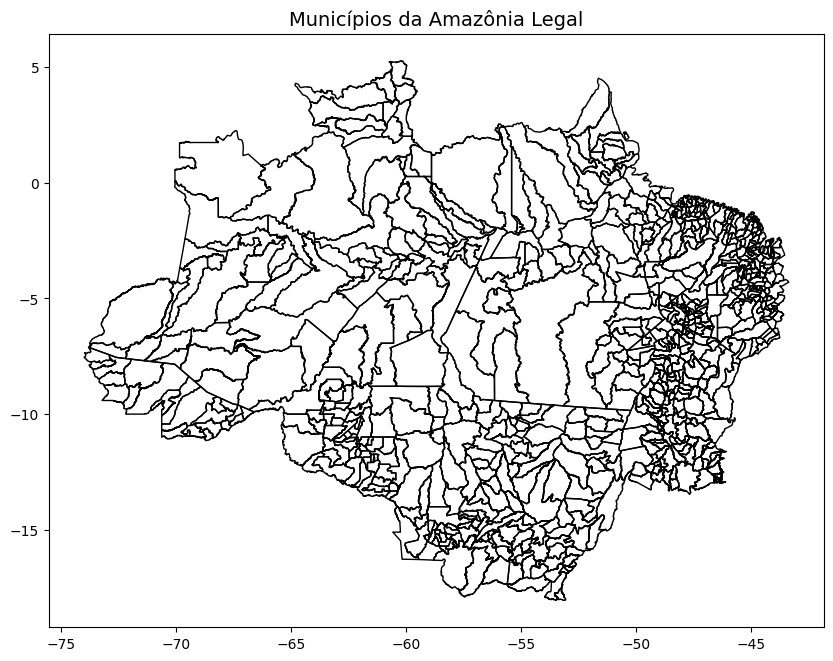

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
municipios.plot(ax=ax, edgecolor="black", facecolor="none")
ax.set_title("Municípios da Amazônia Legal", fontsize=14)
plt.show()


## 2. Carregando o raster de uso e cobertura da terra - TerraClass

In [ ]:
raster_url = (
    "https://info.dengue.mat.br/geoserver/wcs?"
    "service=WCS&"
    "version=1.0.0&"
    "request=GetCoverage&"
    "coverage=amazonia_terraclass:terraclass_AMZ.2008.M&"
    "crs=EPSG:4674&"
    "bbox=-73.98318216,-16.66197917,-43.39929216,5.26958083&"
    "width=800&"
    "height=600&"
    "format=GeoTIFF"
)

response = requests.get(raster_url)
response.raise_for_status()
raster_bytes = BytesIO(response.content)


## 3. Configurando a paleta de cores do raster

In [ ]:
palette = {
    1:  ("#005500", "VEGETACAO NATURAL FLORESTAL PRIMARIA"),
    2:  ("#0fc80f", "VEGETACAO NATURAL FLORESTAL SECUNDARIA"),
    9:  ("#a8a800", "SILVICULTURA"),
    10: ("#e6a04b", "PASTAGEM ARBUSTIVA/ARBOREA"),
    11: ("#ffec87", "PASTAGEM HERBACEA"),
    12: ("#ff8828", "CULTURA AGRICOLA PERENE"),
    13: ("#996400", "CULTURA AGRICOLA SEMIPERENE"),
    16: ("#ad89cd", "MINERACAO"),
    17: ("#ffa8c0", "URBANIZADA"),
    20: ("#e1e1e1", "OUTROS USOS"),
    22: ("#ff0000", "DESFLORESTAMENTO NO ANO"),
    23: ("#0000ff", "CORPO DAGUA"),
    25: ("#ffffff", "NAO OBSERVADO"),
    50: ("#ff00ff", "NAO FLORESTA"),
    52: ("#ffff00", "CULTURA AGRICOLA TEMPORARIA"),
}

codes = sorted(palette.keys())
colors = [palette[val][0] for val in codes]
cmap = mcolors.ListedColormap(colors, name="my_raster_palette")
boundaries = codes + [codes[-1] + 1]
norm = mcolors.BoundaryNorm(boundaries, len(colors))

In [ ]:
with rasterio.open(raster_bytes) as src:
    raster_data = src.read(1)  # Lendo a primeira banda
    raster_data = np.ma.masked_equal(raster_data, src.nodata)  # Máscara para NoData
    raster_transform = src.transform
    raster_crs = src.crs


Antes de entender a criação de colored_raster, precisamos entender o que é raster_data.
Este array contém os valores numéricos do raster, representando as classes de uso e cobertura da terra. O raster_data é um array NumPy 2D, onde cada número representa uma classe do raster.

* Forma do array (shape): (altura, largura), por exemplo, (600, 800).
* Valores numéricos representam diferentes classes (ex.: 11 = pastagem herbácea, 23 = corpo d'água, etc.).


In [ ]:
# Criar um array colorido para o raster
colored_raster = np.zeros((*raster_data.shape, 3), dtype=np.uint8)

for class_id, (color_hex, _) in palette.items():
    color_rgb = np.array([int(color_hex[i:i+2], 16) for i in (1, 3, 5)])  # Converter HEX para RGB
    colored_raster[raster_data == class_id] = color_rgb  # Substituir diretamente onde a condição é verdadeira


O objetivo da linha `np.zeros((*raster_data.shape, 3), dtype=np.uint8)` é criar um novo array tridimensional (altura, largura, 3) onde cada pixel terá um valor RGB (Red, Green, Blue).

* np.zeros(shape, dtype=np.uint8) cria um array preenchido com zeros.
* Forma do array: (*raster_data.shape, 3) = (altura, largura, 3).
* Cada pixel será representado por um vetor [R, G, B] inicializado como [0, 0, 0] (cor preta).
* dtype=np.uint8 significa que os valores vão de 0 a 255 (padrão de imagens RGB).
* (*raster_data.shape, 3)
O operador * desempacota a tupla (altura, largura).

O resultado será um array tridimensional, representando uma imagem colorida, onde cada pixel terá três valores (R, G, B)

```
for class_id, (color_hex, _) in palette.items():
    color_rgb = np.array([int(color_hex[i:i+2], 16) for i in (1, 3, 5)])
    colored_raster[raster_data == class_id] = color_rgb
```

* class_id: recebe o código numérico de cada classe do raster (exemplo: 1, 2, 9).
* color_hex: recebe a cor associada à classe, em formato hexadecimal (exemplo: "#005500").
* _: é um nome de variável para o valor secundário, que é a descrição da classe (exemplo: "VEGETACAO NATURAL FLORESTAL PRIMARIA"), mas ela não é utilizada dentro do loop, por isso é chamada de _.

Dentro do loop, a cor color_hex é dada em formato hexadecimal, e o objetivo é convertê-la para o formato RGB (três valores inteiros que representam as cores vermelho, verde e azul).

* color_hex[i:i+2]: Extrai os valores de cada cor (vermelho, verde, azul) do código hexadecimal.
* color_hex[1:3] → extrai os dois caracteres que representam a componente vermelha da cor.
* color_hex[3:5] → extrai os dois caracteres que representam a componente verde da cor.
* color_hex[5:7] → extrai os dois caracteres que representam a componente azul da cor.
* int(color_hex[i:i+2], 16): Converte cada par de caracteres hexadecimal em um valor inteiro. A função int(..., 16) converte a string hexadecimal para um número inteiro.

Agora que temos a cor RGB associada a uma classe, o próximo passo é substituir todos os valores no raster que pertencem àquela classe pelo valor RGB correspondente.

* `raster_data == class_id`: Esta expressão cria uma máscara booleana onde os valores de raster_data que são iguais a class_id são marcados como True, e os demais são marcados como False.
* Se raster_data contiver, por exemplo, a classe 1, e `class_id == 1`, a expressão resultará em um array de True nas posições onde o valor de raster_data for 1, e False nas outras.
* `colored_raster[raster_data == class_id] = color_rgb`: A expressão `raster_data == class_id` retorna uma matriz booleana que é usada para indexar diretamente os valores de colored_raster. Onde o valor da máscara booleana é `True`, os valores de colored_raster são substituídos pela cor RGB (color_rgb).
* E `class_id == 1`, `color_rgb = [0, 85, 0]` (verde), a substituição será feita nos locais onde raster_data == 1.


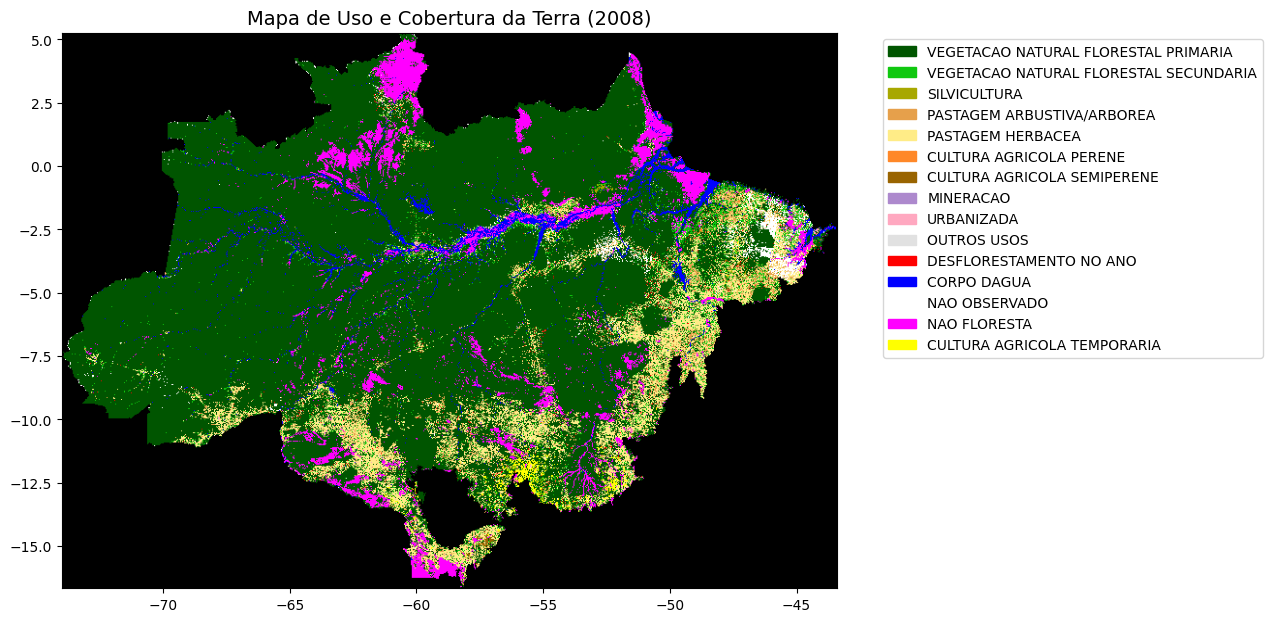

In [ ]:
# Plotar o raster com rasterio.plot.show()
fig, ax = plt.subplots(figsize=(10, 8))
show(colored_raster.transpose((2, 0, 1)), ax=ax, transform=src.transform)
ax.set_title("Mapa de Uso e Cobertura da Terra - TerraClass 2008", fontsize=14)

# Criar a legenda
legend_patches = [mpatches.Patch(color=color_hex, label=label) for color_hex, label in palette.values()]
ax.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc="upper left", fontsize=10)

plt.show()


## 4. Extrair estatísticas dos pixels dentro de cada município

In [ ]:
# Extrair estatísticas dos pixels dentro de cada município
stats = zonal_stats(
    municipios, raster_bytes, categorical=True, nodata=-9999
)

# Criar um DataFrame com os resultados
df_resultados = pd.DataFrame(stats)

# Adicionar os nomes dos municípios
df_resultados.insert(0, "Municipio", municipios["NM_MUN"])  # Ajuste para a coluna correta

# Converter os valores para formato longo
df_resultados = df_resultados.melt(id_vars=["Municipio"], var_name="Classe", value_name="Frequencia")
df_resultados = df_resultados.dropna()

# Salvar os resultados em um CSV
df_resultados.to_csv("frequencia_uso_cobertura_por_municipio.csv", index=False)

# Mostrar as primeiras linhas do resultado
print(df_resultados.head())


                Municipio Classe  Frequencia
0   Alta Floresta D'Oeste      0         8.0
2                  Cabixi      0         3.0
7           Costa Marques      0        13.0
9           Guajará-Mirim      0        33.0
16            Porto Velho      0        13.0


## 5. Criando um gráfico de barras para um município específico

In [ ]:
def plot_distribuicao_classes(municipio_escolhido, df_resultados, palette):
    """
    Plota a distribuição das classes de uso e cobertura da terra para um município específico.

    Parâmetros:
    municipio_escolhido (str): Nome do município a ser analisado.
    df_resultados (DataFrame): DataFrame com as colunas "Municipio", "Classe" e "Frequencia".
    palette (dict): Dicionário com os IDs das classes e suas cores e descrições.
    """

    # Filtra o dataframe para o município escolhido
    df_plot = df_resultados[df_resultados["Municipio"] == municipio_escolhido]

    # Calcula o total de pixels
    total_pixels = df_plot["Frequencia"].sum()

    # Cria a figura
    plt.figure(figsize=(10, 5))

    # Lista para armazenar as barras e as etiquetas da legenda
    bars = []
    labels = []

    # Loop para criar as barras coloridas conforme o palette
    for class_id, (color_hex, descricao) in palette.items():
        # Filtra os dados da classe atual
        class_data = df_plot[df_plot["Classe"] == class_id]

        # Converte a cor HEX para RGB
        color_rgb = np.array([int(color_hex[i:i+2], 16) for i in (1, 3, 5)])

        # Cria as barras
        bar = plt.bar(class_data["Classe"].astype(str), class_data["Frequencia"], color=color_rgb/255)

        # Adiciona a descrição da classe à legenda
        bars.append(bar)
        labels.append(f"Classe {class_id} - {descricao}")

        # Adiciona o valor percentual em cima de cada barra
        for rect in bar:
            height = rect.get_height()  # altura da barra
            percentage = (height / total_pixels) * 100  # percentual
            plt.text(rect.get_x() + rect.get_width() / 2, height, f'{percentage:.1f}%',
                     ha='center', va='bottom', fontsize=10, color='black')

    # Adiciona os rótulos e título
    plt.xlabel("Classe de uso e cobertura da terra")
    plt.ylabel("Frequência de pixels")
    plt.title(f"Distribuição das classes em {municipio_escolhido} - TerraClass, 2008")
    plt.xticks(rotation=45)

    # Adiciona a legenda fora do gráfico à direita
    plt.legend(bars, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

    # Ajusta o layout para garantir que tudo seja exibido corretamente
    plt.tight_layout()

    # Exibe o gráfico
    plt.show()


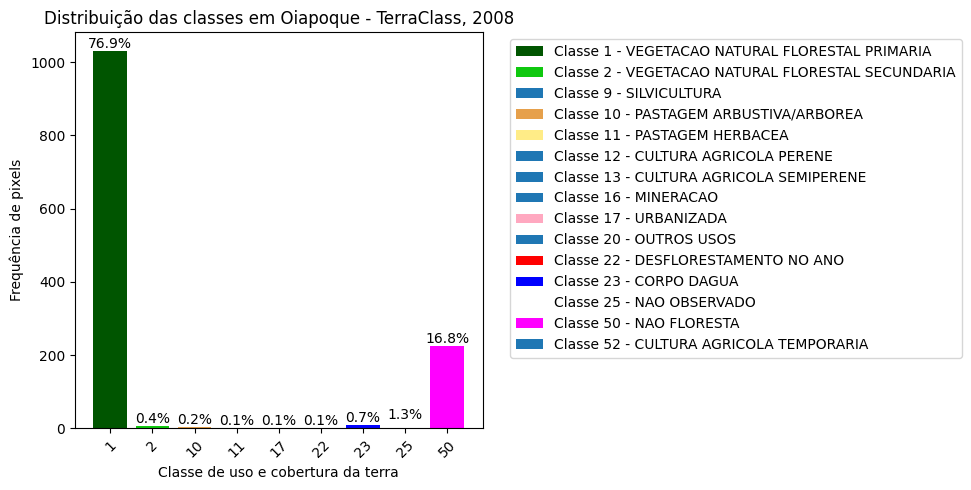

In [ ]:
municipio_escolhido = "Oiapoque"
plot_distribuicao_classes(municipio_escolhido, df_resultados, palette)

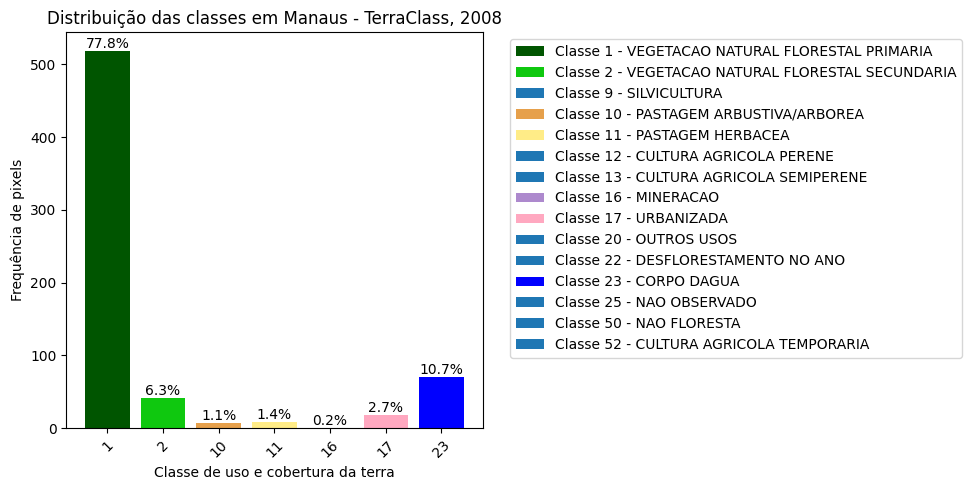

In [109]:
plot_distribuicao_classes("Manaus", df_resultados, palette)

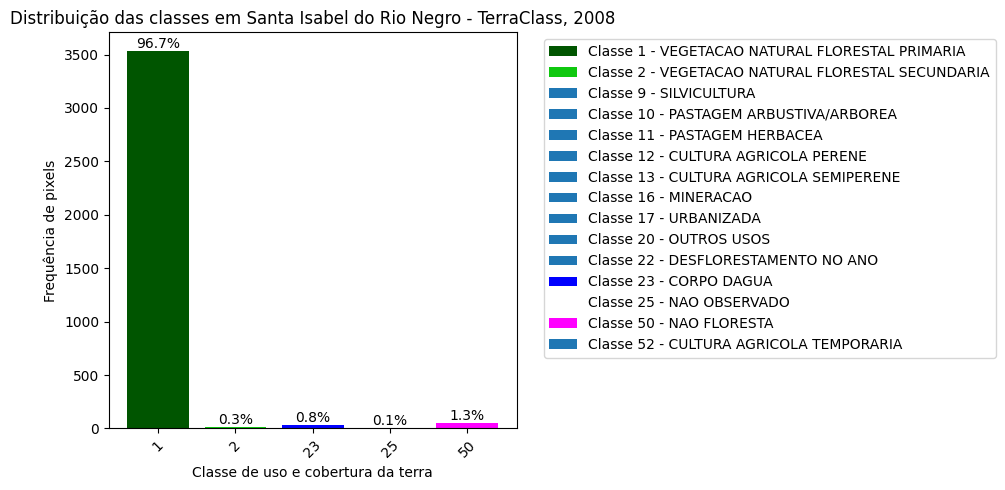

In [110]:
plot_distribuicao_classes("Santa Isabel do Rio Negro", df_resultados, palette)

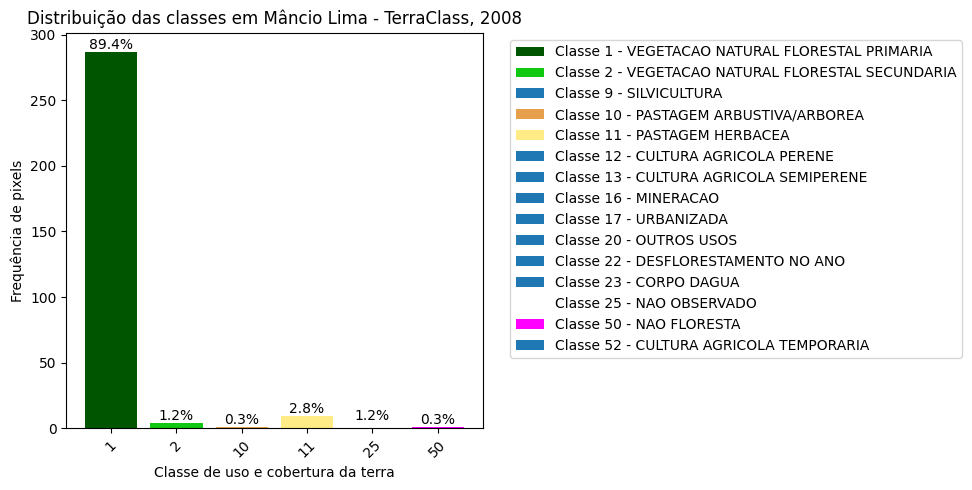

In [111]:
plot_distribuicao_classes("Mâncio Lima", df_resultados, palette)